In [1]:
import pandas as pd
import numpy as np
from category_encoders import BinaryEncoder
from sklearn.ensemble import RandomForestRegressor

pip install category_encoders

### Read train data and test data

In [23]:
df_train = pd.read_csv("train.csv")
print('Number of train records: {}'.format(len(df_train)))
df_train.head()

Number of train records: 60000


,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,103.938717,0.0,bedok north,bedok,east region,2250
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1972,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100


In [3]:
df_test = pd.read_csv("test.csv")
print('Number of test records: {}'.format(len(df_test)))
df_test.head()

Number of test records: 30000


,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region
0,2023-01,hougang,245,hougang street 22,5-room,improved,121.0,yes,1984,1.358411,103.891722,0.0,lorong ah soo,hougang,north-east region
1,2022-09,sembawang,316,sembawang vista,4-room,model a,100.0,yes,1999,1.446343,103.820817,0.0,sembawang central,sembawang,north region
2,2023-07,clementi,708,Clementi West Street 2,4-room,new generation,91.0,yes,1980,1.305719,103.762168,0.0,clementi west,clementi,west region
3,2021-08,jurong east,351,Jurong East Street 31,3 room,model a,74.0,yes,1986,1.344832,103.730778,0.0,yuhua west,jurong east,west region
4,2022-03,jurong east,305,jurong east street 32,5-room,improved,121.0,yes,1983,1.345437,103.735241,0.0,yuhua west,jurong east,west region


# Visualization

<ipython-input-4-c6b19ea60e88>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(ylabels)


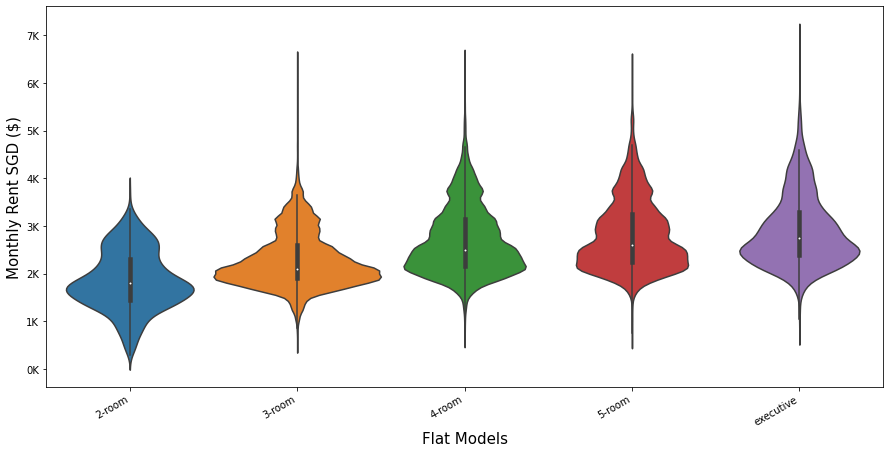

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
# Violin plots for price distribution of each flat model

fig = plt.figure(figsize=(15,7))
p=sns.violinplot(x='flat_type', y='monthly_rent', data=df_train, width=1,
                order=df_train.groupby('flat_type')['monthly_rent'].mean().sort_values().reset_index()['flat_type'].tolist())
p.set_xticklabels(p.get_xticklabels(), rotation=30, ha='right'), p.set_xlabel('Flat Models', size=15)
ylabels = ['{:,.0f}'.format(x) + 'K' for x in p.get_yticks()/1000]
p.set_yticklabels(ylabels)
p.set_ylabel('Monthly Rent SGD ($)', size=15)
plt.show()

<ipython-input-5-57aaeb52f4d9>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(ylabels)


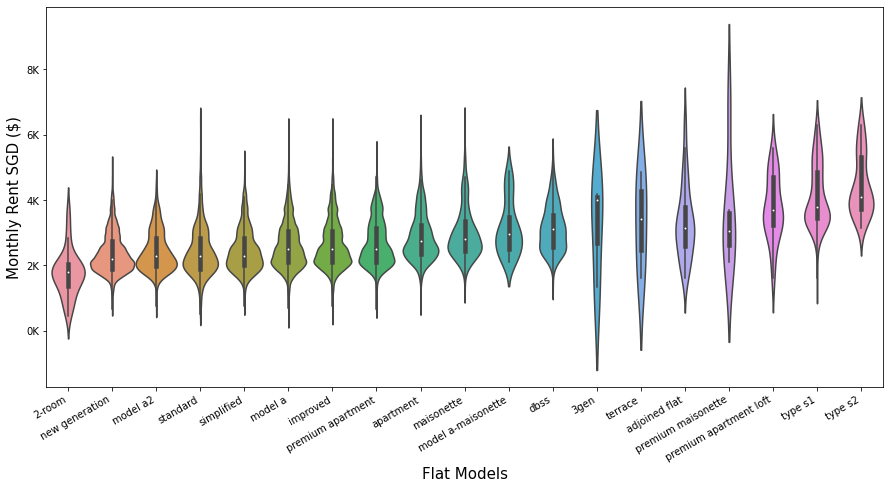

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
# Violin plots for price distribution of each flat model

fig = plt.figure(figsize=(15,7))
p=sns.violinplot(x='flat_model', y='monthly_rent', data=df_train, width=1,
                order=df_train.groupby('flat_model')['monthly_rent'].mean().sort_values().reset_index()['flat_model'].tolist())
p.set_xticklabels(p.get_xticklabels(), rotation=30, ha='right'), p.set_xlabel('Flat Models', size=15)
ylabels = ['{:,.0f}'.format(x) + 'K' for x in p.get_yticks()/1000]
p.set_yticklabels(ylabels)
p.set_ylabel('Monthly Rent SGD ($)', size=15)
plt.show()

## Observe some strange things

In [4]:
df_2_room = df_train.loc[df_train["flat_model"]=="2-room"]
df_2_room["flat_type"].unique()

array(['2 room', '2-room'], dtype=object)

In [5]:
df_reverse2 = df_train.loc[df_train["flat_type"]=="2-room"]
df_reverse2["flat_model"].unique()

array(['model a', 'improved', 'standard', '2-room', 'premium apartment'],
      dtype=object)

# Useful functions for encoding

## One-hot encoding

In [22]:
def one_hot_encode_column(df, column_name, order, status, rank = 0):
    # Extract the specified column from the DataFrame
    column = df[column_name]
    
    if status == "train":
        # Get unique values in the column
        unique_values = column.unique()

        if rank != 0:
            unique_values = df.groupby(column_name)['monthly_rent'].mean().sort_values().reset_index()[column_name].tolist()
            
    if status == "test":
        unique_values = order
    
    # Create a new DataFrame with binary columns
    binary_columns = pd.DataFrame(0, columns=unique_values, index=df.index)
#     name_columns = [f"{column_name}_{value}" for value in unique_values]
#     binary_columns = pd.DataFrame(0, columns=name_columns, index=df.index)
    
    # Set binary values based on one-hot encoding
    for value in unique_values:
#     for value in name_columns:
        binary_columns.loc[column == value, value] = 1
    
    # Concatenate the binary columns into a single column with binary strings
#     df[column_name] = binary_columns.apply(lambda row: ''.join(map(str, row)), axis=1)
    df = pd.concat([df, binary_columns], axis=1)
    df.drop(columns=[column_name], inplace=True)
    #Rename column
    for name in unique_values:
        df = df.rename(columns={name: f"{column_name}_{name}"})
    
    
    return df, unique_values

# Example usage:
# Assuming you have a DataFrame df and you want to one-hot encode the "Category" column
# df = one_hot_encode_column(df, "Category")

## Rank encoding

In [7]:
def rank_encode_column(df, column_name, order, status, rank = 0):
    # Extract the specified column from the DataFrame
    column = df[column_name]
    
    if status == "train":
        # Get unique values in the column
        unique_values = column.unique()

        if rank != 0:
            unique_values = df.groupby(column_name)['monthly_rent'].mean().sort_values().reset_index()[column_name].tolist()
            
    if status == "test":
        unique_values = order
        
    value_to_rank = {value: rank for rank, value in enumerate(unique_values, 1)}
    
    # Create a new column with rank values
    df[column_name] = column.map(value_to_rank)
    
    return df, unique_values

# Example usage:
# Assuming you have a DataFrame df and you want to rank encode the "Category" column
# df = rank_encode_column(df, "Category")

In [24]:
df_train, order_flat_type = one_hot_encode_column(df_train, 'flat_type',1,"train",1)

In [25]:
df_train, order_flat_model = rank_encode_column(df_train, 'flat_model',1,"train","hi")

In [26]:
df_train.head()

,rent_approval_date,town,block,street_name,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,...,monthly_rent,flat_type_2 room,flat_type_3 room,flat_type_2-room,flat_type_4 room,flat_type_5 room,flat_type_3-room,flat_type_executive,flat_type_4-room,flat_type_5-room
0,2021-09,jurong east,257,Jurong East Street 24,2,67.0,yes,1983,1.344518,103.738630,...,1600,0,1,0,0,0,0,0,0,0
1,2022-05,bedok,119,bedok north road,2,92.0,yes,1978,1.330186,103.938717,...,2250,0,0,0,0,0,0,0,1,0
2,2022-10,toa payoh,157,lorong 1 toa payoh,7,67.0,yes,1971,1.332242,103.845643,...,1900,0,0,0,0,0,1,0,0,0
3,2021-08,pasir ris,250,Pasir Ris Street 21,9,149.0,yes,1993,1.370239,103.962894,...,2850,0,0,0,0,0,0,1,0,0
4,2022-11,kallang/whampoa,34,Whampoa West,7,68.0,yes,1972,1.320502,103.863341,...,2100,0,0,0,0,0,1,0,0,0


In [11]:
print(order_flat_type)

['2 room', '3 room', '2-room', '4 room', '5 room', '3-room', 'executive', '4-room', '5-room']


# Random Forest with SKLearn

### Use RandomForestRegressor from sklearn

In [13]:
# form input and output
x = df_train[['flat_type','flat_model']].copy()
# x = df_train.iloc[:, : -1]
# y = df_train.iloc[:, -1:]
y = df_train.iloc[:, -1:].values.flatten()

In [14]:
print(y)

[1600 2250 1900 ... 2250 4700 2850]


In [15]:
#Assume now all the values are numerical
# create regressor object
regressor = RandomForestRegressor(n_estimators=100,
                                  random_state=0)
 
# fit the regressor with x and y data
regressor.fit(x, y)

RandomForestRegressor(random_state=0)

In [16]:
df_test,_ = one_hot_encode_column(df_test, 'flat_type', order_flat_type, "test")
df_test,_ = rank_encode_column(df_test, 'flat_model', order_flat_model, "test")
X = df_test[['flat_type','flat_model']].copy()

In [17]:
# test the output by changing values
Y_pred = regressor.predict(X)

In [18]:
df_test['Predict_Price'] = Y_pred.tolist()
df_test.head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,lease_commence_date,latitude,longitude,subzone,planning_area,region,Predict_Price
0,2023-01,hougang,245,hougang street 22,00010,7,121.0,1984,1.358411,103.891722,lorong ah soo,hougang,north-east region,2810.675488
1,2022-09,sembawang,316,sembawang vista,00100,6,100.0,1999,1.446343,103.820817,sembawang central,sembawang,north region,2703.920330
2,2023-07,clementi,708,Clementi West Street 2,00100,2,91.0,1980,1.305719,103.762168,clementi west,clementi,west region,2661.005444
3,2021-08,jurong east,351,Jurong East Street 31,01000,6,74.0,1986,1.344832,103.730778,yuhua west,jurong east,west region,2322.995337
4,2022-03,jurong east,305,jurong east street 32,00010,7,121.0,1983,1.345437,103.735241,yuhua west,jurong east,west region,2810.675488


# Reference
### flat_type
https://www.hdb.gov.sg/residential/buying-a-flat/finding-a-flat/types-of-flats
### flat_model
https://www.teoalida.com/singapore/hdbflattypes/